# Train classification model with OpenAE features

In [2]:
from urllib.request import urlretrieve
import numpy as np
import openae.features
import pandas as pd
import seaborn as sns
import skl2onnx
import sklearn
import vallenae

## Download pmma-plate-sources dataset

In [3]:
urlretrieve("https://filetransfer.vallen.de/openae/datasets/pmma-plate-sources/plb.tradb", filename="plb.tradb")
urlretrieve("https://filetransfer.vallen.de/openae/datasets/pmma-plate-sources/salt.tradb", filename="salt.tradb")
urlretrieve("https://filetransfer.vallen.de/openae/datasets/pmma-plate-sources/pulse.tradb", filename="pulse.tradb")

('pulse.tradb', <http.client.HTTPMessage at 0x1ade50b27d0>)

## Extract features

In [4]:
def compute_feature_vector(timedata: np.ndarray, samplerate: float):
    input_ = openae.features.Input(samplerate=samplerate, timedata=timedata, spectrum=np.fft.rfft(timedata))
    return {
        "clearance-factor":         openae.features.clearance_factor(input_),
        "crest-factor":             openae.features.crest_factor(input_),
        "energy":                   openae.features.energy(input_),
        "impulse-factor":           openae.features.impulse_factor(input_),
        "kurtosis":                 openae.features.kurtosis(input_),
        "partial-power_50-100kHz":  openae.features.partial_power(input_, 50e3, 100e3),
        "partial-power_100-150kHz": openae.features.partial_power(input_, 100e3, 150e3),
        "partial-power_150-200kHz": openae.features.partial_power(input_, 150e3, 200e3),
        "partial-power_200-300kHz": openae.features.partial_power(input_, 200e3, 300e3),
        "peak-amplitude":           openae.features.peak_amplitude(input_),
        "rms":                      openae.features.rms(input_),
        "shape-factor":             openae.features.shape_factor(input_),
        "skewness":                 openae.features.skewness(input_),
        "spectral-centroid":        openae.features.spectral_centroid(input_),
        "spectral-flatness":        openae.features.spectral_flatness(input_),
        "spectral-kurtosis":        openae.features.spectral_kurtosis(input_),
        "spectral-peak-frequency":  openae.features.spectral_peak_frequency(input_),
        "spectral-rolloff_0.5":     openae.features.spectral_rolloff(input_, 0.5),
        "spectral-rolloff_0.8":     openae.features.spectral_rolloff(input_, 0.8),
        "spectral-rolloff_0.9":     openae.features.spectral_rolloff(input_, 0.9),
        "spectral-skewness":        openae.features.spectral_skewness(input_),
        "spectral-variance":        openae.features.spectral_variance(input_),
        "zero-crossing-rate":       openae.features.zero_crossing_rate(input_),
    }

In [5]:
%%time
def extract_features_from_file(filepath) -> pd.DataFrame:
    with vallenae.io.TraDatabase(filepath) as tradb:
        return pd.DataFrame(compute_feature_vector(tra.data, tra.samplerate) for tra in tradb.iread())

df = pd.concat(
    [
        extract_features_from_file("plb.tradb").assign(label="plb"),
        extract_features_from_file("salt.tradb").assign(label="salt"),
        extract_features_from_file("pulse.tradb").assign(label="pulse"),
    ],
    ignore_index=True,
).astype({"label": "category"})

df

CPU times: total: 391 ms
Wall time: 386 ms


,clearance-factor,crest-factor,energy,impulse-factor,kurtosis,partial-power_50-100kHz,partial-power_100-150kHz,partial-power_150-200kHz,partial-power_200-300kHz,peak-amplitude,...,spectral-flatness,spectral-kurtosis,spectral-peak-frequency,spectral-rolloff_0.5,spectral-rolloff_0.8,spectral-rolloff_0.9,spectral-skewness,spectral-variance,zero-crossing-rate,label
0,66.145302,8.020178,2.108724e-08,23.967041,24.871826,0.068285,0.152450,0.715541,0.063537,0.027812,...,2.593422e-06,5.462217,160241.781250,159671.531250,165944.343750,177349.453125,0.005498,708364352.0,291970.81250,plb
1,80.519295,8.945949,2.414062e-08,27.770651,28.150253,0.078846,0.113323,0.778009,0.029640,0.034339,...,2.627033e-06,5.368741,162353.515625,161743.156250,168457.031250,181274.406250,-0.779269,631162048.0,300903.31250,plb
2,59.492359,7.509295,2.409282e-08,21.559280,23.858864,0.039208,0.074003,0.799019,0.087624,0.029556,...,2.047423e-06,6.793591,159465.015625,159465.015625,167181.062500,186471.187500,0.213307,613175168.0,272633.71875,plb
3,111.982124,9.519390,3.825558e-08,34.097557,36.193626,0.023017,0.066928,0.843945,0.065977,0.038629,...,1.578464e-06,8.871037,159693.531250,160554.406250,165289.250000,180354.687500,0.269293,435700032.0,294421.46875,plb
4,82.699471,8.673425,3.473449e-08,26.140079,24.551796,0.032062,0.100731,0.792985,0.074104,0.038462,...,1.700693e-06,7.161076,159080.609375,159080.609375,167006.343750,184556.156250,0.352548,575168896.0,298346.90625,plb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,57.528671,6.051083,9.659900e-08,18.382334,18.291368,0.000026,0.096082,0.902984,0.000909,0.039512,...,1.580904e-07,21.606930,154043.078125,154043.078125,155808.609375,156691.390625,-1.041255,38712356.0,316031.06250,pulse
836,46.396965,6.799486,3.175715e-08,17.725124,17.316172,0.000072,0.219570,0.777572,0.002786,0.026944,...,3.891438e-07,43.285671,150810.906250,151305.375000,153777.703125,156744.453125,2.079208,41675824.0,308544.31250,pulse
837,97.140190,7.356155,9.567211e-08,26.110649,24.124409,0.000034,0.169241,0.830131,0.000594,0.043939,...,1.962726e-07,14.693414,154385.437500,154385.437500,156622.906250,157741.656250,-1.206947,48090432.0,299075.15625,pulse
838,57.418987,6.052019,9.665842e-08,18.382162,18.292469,0.000026,0.096252,0.902814,0.000908,0.039530,...,1.683236e-07,21.676767,154043.078125,154043.078125,155808.609375,156691.390625,-1.042703,38765600.0,317355.21875,pulse


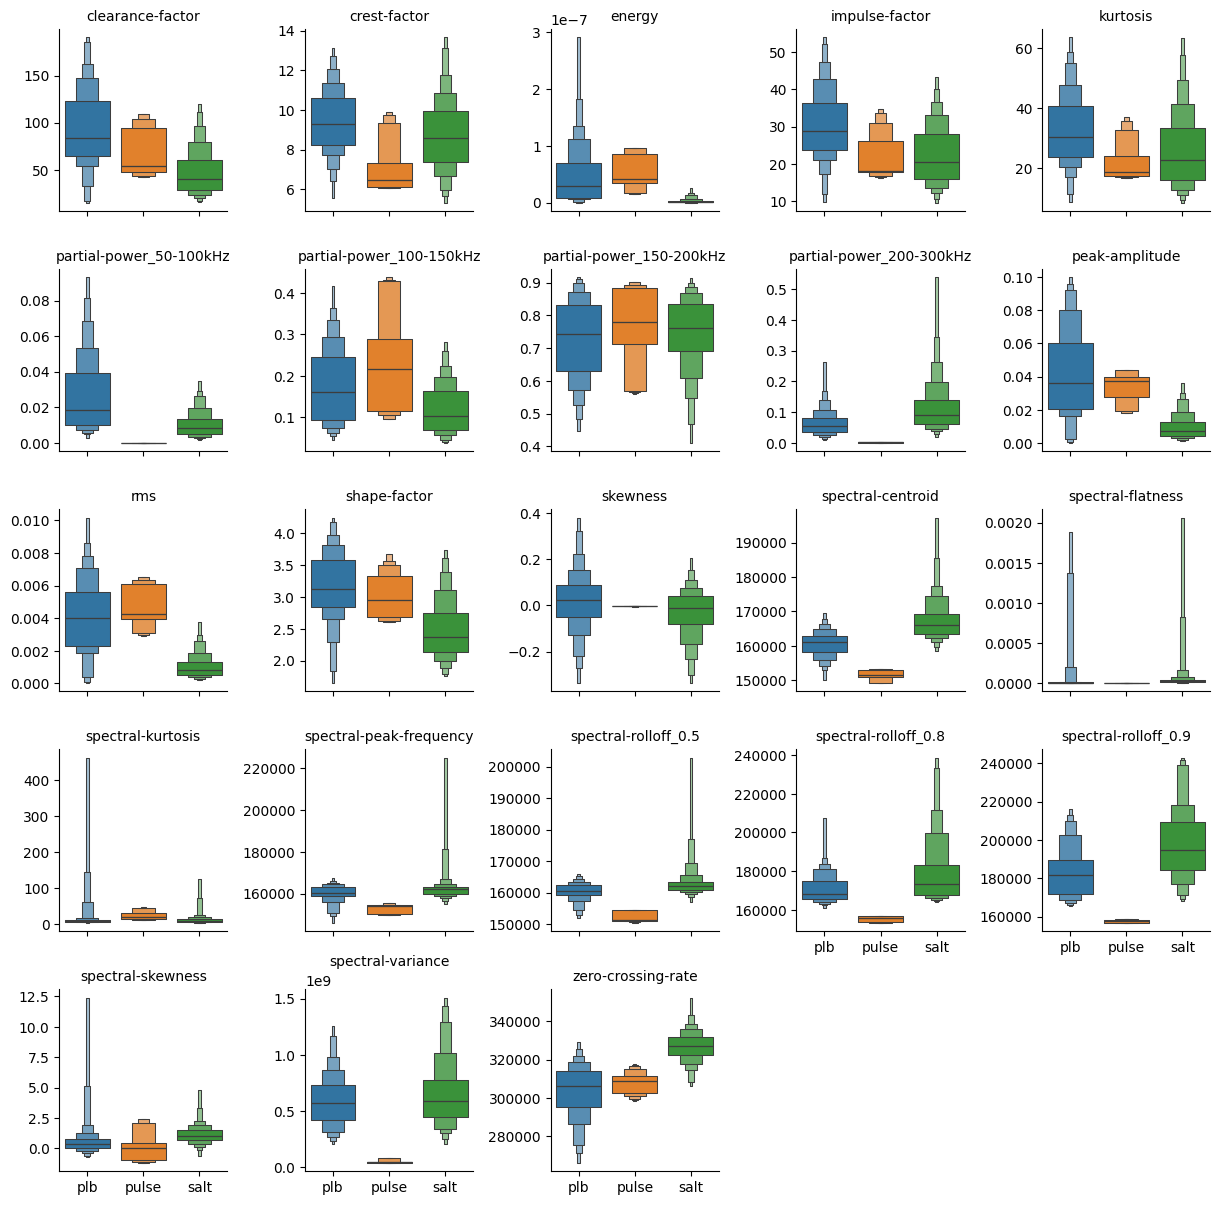

In [6]:
sns.catplot(
    df.melt(id_vars="label", var_name="feature", value_name="value"),
    x="label",
    y="value",
    hue="label",
    col="feature",
    col_wrap=5,
    height=2.5,
    kind="boxen",
    sharey=False,
    showfliers=False,
).set_titles("{col_name}").set(xlabel=None, ylabel=None)

## Train/test split

In [7]:
X = df.drop(columns="label").to_numpy()
y = df["label"].cat.codes.to_numpy()

feature_names = df.drop(columns="label").columns
label_names = df["label"].cat.categories

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.25, stratify=y, random_state=1)

## Train model

In [8]:
scaler = sklearn.preprocessing.StandardScaler()
clf = sklearn.svm.LinearSVC()
pipeline = sklearn.pipeline.make_pipeline(scaler, clf)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])

## Scores & confusion matrix

Accuracy: 0.9666666666666667
              precision    recall  f1-score   support

         plb       0.93      0.97      0.95        66
       pulse       0.99      1.00      0.99        71
        salt       0.99      0.93      0.96        73

    accuracy                           0.97       210
   macro avg       0.97      0.97      0.97       210
weighted avg       0.97      0.97      0.97       210



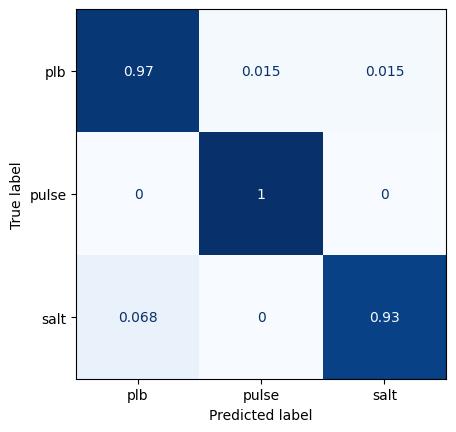

In [9]:
y_test_pred = pipeline.predict(X_test)
print("Accuracy:", sklearn.metrics.accuracy_score(y_test, y_test_pred))
print(sklearn.metrics.classification_report(y_test, y_test_pred, target_names=label_names))

cm = sklearn.metrics.confusion_matrix(y_test, y_test_pred, normalize="true")
sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names).plot(cmap="Blues", colorbar=False)

In [10]:
sklearn.model_selection.cross_validate(pipeline, X, y, return_train_score=True)

{'fit_time': array([0.00776339, 0.00489354, 0.        , 0.01598263, 0.        ]),
 'score_time': array([0.00410867, 0.        , 0.        , 0.        , 0.        ]),
 'test_score': array([0.94642857, 0.95238095, 0.95833333, 0.98214286, 0.95238095]),
 'train_score': array([0.98214286, 0.97767857, 0.98214286, 0.97470238, 0.97767857])}

## Feature importances

<Axes: >

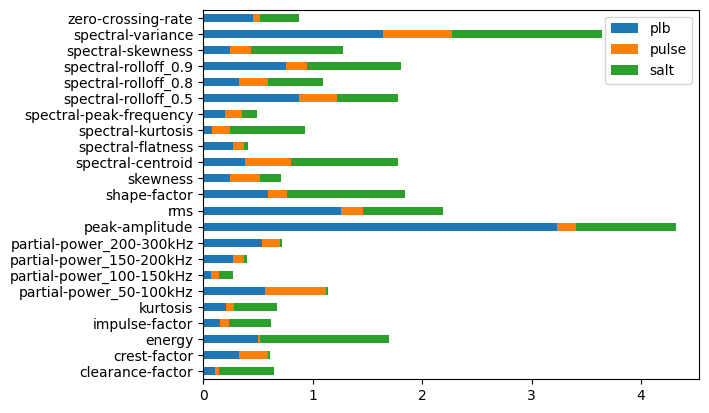

In [11]:
df_coef = pd.DataFrame(np.abs(clf.coef_).T, index=feature_names, columns=label_names)
df_coef.plot(kind="barh", stacked=True)

## Export as ONNX model

In [12]:
onnx_model = skl2onnx.to_onnx(
    pipeline,
    initial_types=[(name, skl2onnx.common.data_types.FloatTensorType([1, 1])) for name in feature_names],
    options={"output_class_labels": True}
)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())